In [23]:
import pandas as pd
import matplotlib.pyplot as plt 
import re
from datetime import datetime, time
import textdistance
import numpy as np
%matplotlib inline

DATA_DIR = '../../data/'

In [24]:
# !pip install textdistance

In [25]:
def validate_route(r):
    return len(r) == 1 or r == "SI"

In [26]:
routes = pd.read_csv(DATA_DIR + 'raw/google_transit/routes.txt')
routes = routes[(routes.route_type == 1)]
routes = routes[routes.route_id.apply(validate_route)]
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,1,MTA NYCT,1,Broadway - 7 Avenue Local,Trains operate between 242 St in the Bronx and...,1,http://web.mta.info/nyct/service/pdf/t1cur.pdf,EE352E,NaN
1,2,MTA NYCT,2,7 Avenue Express,"Trains operate between Wakefield-241 St, Bronx...",1,http://web.mta.info/nyct/service/pdf/t2cur.pdf,EE352E,
2,3,MTA NYCT,3,7 Avenue Express,"Trains operate between 148 St, 7 Av, Manhattan...",1,http://web.mta.info/nyct/service/pdf/t3cur.pdf,EE352E,NaN
3,4,MTA NYCT,4,Lexington Avenue Express,Trains operate daily between Woodlawn/Jerome A...,1,http://web.mta.info/nyct/service/pdf/t4cur.pdf,00933C,NaN
4,5,MTA NYCT,5,Lexington Avenue Express,"Weekdays daytime, most trains operate between ...",1,http://web.mta.info/nyct/service/pdf/t5cur.pdf,00933C,NaN


In [27]:
stops = pd.read_csv(DATA_DIR + 'raw/google_transit/stops.txt')
platforms = stops[stops.location_type == 0][['stop_id', 'stop_name']]
platforms.head()

,stop_id,stop_name
1,101N,Van Cortlandt Park - 242 St
2,101S,Van Cortlandt Park - 242 St
4,103N,238 St
5,103S,238 St
7,104N,231 St


In [28]:
def fix_24h(timestamp):
    hour = int(timestamp[:2])
    if hour >= 24: 
        return f"{hour % 24}{timestamp[2:]}"
    return timestamp

def convert_times(timestamp):
    return datetime.strptime(fix_24h(timestamp), '%H:%M:%S').time()
        
stop_times = pd.read_csv(DATA_DIR + 'raw/google_transit/stop_times.txt')
#stop_times[["arrival_time", "departure_time"]] = stop_times[["arrival_time", "departure_time"]].apply(convert_times)
stop_times.arrival_time = stop_times.arrival_time.apply(convert_times)
stop_times = stop_times[(stop_times.arrival_time >= time(hour=7)) & (stop_times.arrival_time <= time(hour=19)) ]
stop_times[stop_times.arrival_time == stop_times.arrival_time.max()]
#stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
4477,AFA19GEN-1037-Sunday-00_109350_1..S03R,19:00:00,19:00:00,134S,32,NaN,0,0,NaN
4574,AFA19GEN-1037-Sunday-00_111750_1..S03R,19:00:00,19:00:00,117S,15,NaN,0,0,NaN
8662,AFA19GEN-1037-Sunday-00_108450_1..N03R,19:00:00,19:02:00,103N,37,NaN,0,0,NaN
8761,AFA19GEN-1037-Sunday-00_110850_1..N03R,19:00:00,19:00:00,119N,22,NaN,0,0,NaN
8827,AFA19GEN-1037-Sunday-00_112450_1..N03R,19:00:00,19:00:00,129N,12,NaN,0,0,NaN
15294,AFA19GEN-1038-Saturday-00_111150_1..S03R,19:00:00,19:00:00,121S,19,NaN,0,0,NaN
15393,AFA19GEN-1038-Saturday-00_113550_1..S03R,19:00:00,19:00:00,106S,4,NaN,0,0,NaN
20175,AFA19GEN-1038-Saturday-00_108700_1..N03R,19:00:00,19:00:00,104N,36,NaN,0,0,NaN
20274,AFA19GEN-1038-Saturday-00_111100_1..N03R,19:00:00,19:00:00,120N,21,NaN,0,0,NaN
27805,AFA19GEN-1087-Weekday-00_108750_1..S03R,19:00:00,19:00:00,138S,36,NaN,0,0,NaN


In [29]:
#stop_times['arrival_time'] = pd.to_datetime(stop_times.arrival_time, format="%H:%M:%S")
#stop_times[stop_times.arrival_time.between_time('8:00', '19:00')]

In [30]:
weekday = stop_times[stop_times.trip_id.str.contains('Weekday')] # filter to weekday
weekday.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
23103,AFA19GEN-1087-Weekday-00_036500_1..S03R,07:00:00,07:00:00,142S,38,NaN,0,0,NaN
23136,AFA19GEN-1087-Weekday-00_037300_1..S03R,07:01:00,07:01:00,135S,33,NaN,0,0,NaN
23137,AFA19GEN-1087-Weekday-00_037300_1..S03R,07:02:00,07:02:00,136S,34,NaN,0,0,NaN
23138,AFA19GEN-1087-Weekday-00_037300_1..S03R,07:03:00,07:03:00,137S,35,NaN,0,0,NaN
23139,AFA19GEN-1087-Weekday-00_037300_1..S03R,07:04:30,07:04:30,138S,36,NaN,0,0,NaN


In [31]:
def get_pairs(l):
    return [f"{l[i]},{l[i+1]}" for i in range(len(l) - 1)]

In [32]:
trip_conns = weekday.sort_values(['stop_sequence']).groupby(['trip_id'], sort=False)['stop_id'].apply(list).reset_index(name='stations')
trip_conns['stations'] = trip_conns['stations'].apply(get_pairs) # get pairs of stops
trip_conns = trip_conns.set_index('trip_id').stations.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'stations'}) # explode result
trip_conns.head()

,trip_id,stations
0,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D40N,D39N"
1,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D39N,D35N"
2,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D35N,D31N"
3,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D31N,D28N"
4,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D28N,D26N"


In [33]:
line_conns = trip_conns
line_conns['line'] = line_conns.trip_id.str.extract(r'.*_(\w*)\..*') # extract line from trip id
line_conns = line_conns[line_conns.line.apply(validate_route)] # remove special case lines
line_conns.head()

,trip_id,stations,line
0,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D40N,D39N",B
1,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D39N,D35N",B
2,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D35N,D31N",B
3,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D31N,D28N",B
4,BFA19GEN-B081-Weekday-00_091800_B..N45R,"D28N,D26N",B


In [34]:
station_conns = line_conns
station_conns = station_conns.groupby(['line', 'stations']).size().to_frame('num_trips').reset_index() # get trips between stations by line
station_conns[['from','to']] = station_conns.stations.str.split(",", expand=True)
station_conns.head(3)

,line,stations,num_trips,from,to
0,1,"101S,103S",132,101S,103S
1,1,"103N,101N",130,103N,101N
2,1,"103S,104S",145,103S,104S


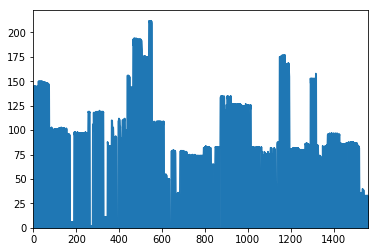

In [35]:
station_conns.num_trips.plot(kind='area')

In [40]:
t = station_conns
t = t[(t.num_trips < 10)]
t = pd.merge(t, platforms.rename(columns={'stop_name':'from_name', 'stop_id':'from'}))
t = pd.merge(t, platforms.rename(columns={'stop_name':'to_name', 'stop_id':'to'}))
t.head()


,line,stations,num_trips,from,to,from_name,to_name
0,2,"239S,248S",5,239S,248S,Franklin Av,Nostrand Av
1,2,"248N,239N",6,248N,239N,Nostrand Av,Franklin Av
2,2,"248S,249S",5,248S,249S,Nostrand Av,Kingston Av
3,2,"249N,248N",6,249N,248N,Kingston Av,Nostrand Av
4,2,"249S,250S",5,249S,250S,Kingston Av,Crown Hts - Utica Av


In [37]:
line_conns[(line_conns.stations=="619N,613N")&(line_conns.line=="6")]


,trip_id,stations,line
20,AFA19GEN-6086-Weekday-00_106300_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_093400_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_079800_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_082200_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_107000_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_095600_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_108750_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_102150_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_077400_6..N02R,"619N,613N",6
20,AFA19GEN-6086-Weekday-00_104550_6..N02R,"619N,613N",6


In [38]:
stop_times[stop_times.trip_id=="AFA19GEN-6086-Weekday-00_098000_6..N02R"]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
177469,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:20:00,16:20:00,640N,1,NaN,0,0,NaN
177470,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:22:00,16:22:00,639N,2,NaN,0,0,NaN
177471,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:23:30,16:23:30,638N,3,NaN,0,0,NaN
177472,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:24:30,16:24:30,637N,4,NaN,0,0,NaN
177473,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:26:00,16:26:00,636N,5,NaN,0,0,NaN
177474,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:27:30,16:27:30,635N,6,NaN,0,0,NaN
177475,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:29:30,16:29:30,634N,7,NaN,0,0,NaN
177476,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:30:30,16:30:30,633N,8,NaN,0,0,NaN
177477,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:31:30,16:31:30,632N,9,NaN,0,0,NaN
177478,AFA19GEN-6086-Weekday-00_098000_6..N02R,16:33:30,16:33:30,631N,10,NaN,0,0,NaN


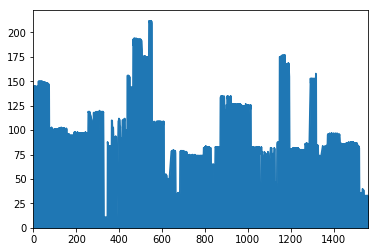

In [45]:
filter_conns = station_conns[station_conns.num_trips >= 10]
filter_conns.num_trips.plot(kind='area')

In [ ]:
filter_conns[['from', 'to', 'line']].to_csv(DATA_DIR + 'processed/station_to_station.csv')